In [1]:
import os
import time
import sys
import json
from datetime import datetime
sys.path.append("/global/homes/s/seanjx/gigalens/src")

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import tensorflow_probability.substrates.jax as tfp

import jax
from jax import random
from jax import numpy as jnp

import numpy as np
import optax
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.visualization import simple_norm

import myfunctions
from myfunctions import printToFile

from corner import corner

tfd = tfp.distributions

/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#create output directory
now = "238_"+str(datetime.now())

path = "output/"+now+"/"
os.makedirs(path)
print(now)

238_2024-07-18 10:26:47.191400


-0.016668702


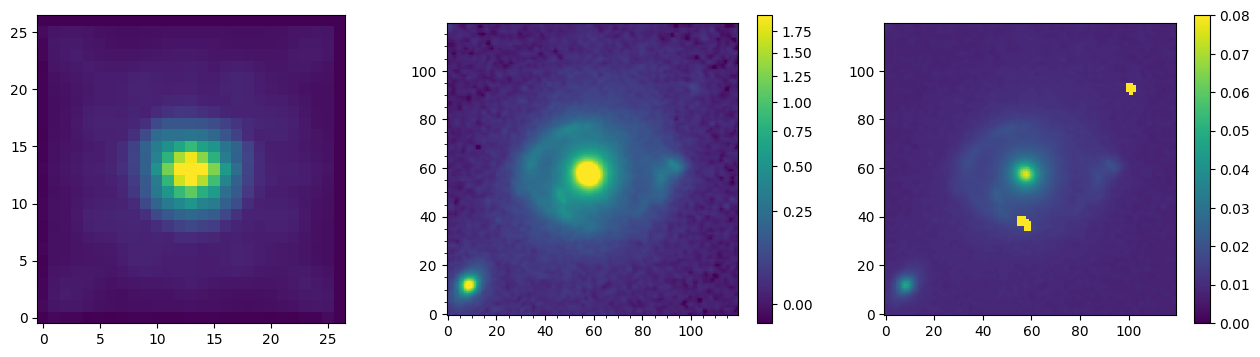

In [3]:
#load observation data, do masking
f=fits.open('psf238.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout238b.npy")

f=fits.open('final_94_drz.fits')
background_rms=0.00766512
exp_time=f[0].header["EXPTIME"]
deltaPix = f[0].header["D002SCAL"]
numPix = np.shape(observed_img)[0]

err_map = np.sqrt(background_rms**2 + observed_img/exp_time)
threshold_lens=1.
error_masked=err_map
#error_masked[50:70,50:70]=np.where(observed_img[50:70,50:70]>1.2, 120000, error_masked[50:70,50:70]) #mask the lens
# error_masked[70:80,0:80]=np.where(observed_img[70:80,0:80]>-0.1, 120000, error_masked[70:80,0:80])
# error_masked[0:10,0:80]=np.where(observed_img[0:10,0:80]>0, 120000, error_masked[0:10,0:80])
error_masked[90:100,100:110]=np.where(observed_img[90:100,100:110]>0.05, 120000, error_masked[90:100,100:110])
error_masked[30:40,55:65]=np.where(observed_img[30:40,55:65]>0.25, 120000, error_masked[30:40,55:65])



plt.figure(figsize=(16,4))
norm = simple_norm(psf, 'sqrt', percent=99.)
plt.subplot(131)
plt.imshow(psf, norm=norm, origin='lower', cmap='viridis')


norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.subplot(132)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.minorticks_on()
#plt.grid(which="both",visible=True)

plt.subplot(133)
plt.imshow(err_map, vmin=0,vmax=0.08, origin='lower')
plt.colorbar()

np.save(path+"/err_map.npy",err_map)
print(np.min(observed_img))

In [4]:
prior, phys_model = myfunctions.readJson("prior.json")[0:2]
os.popen(f'cp prior.json "{path}prior.json"')

sim_config = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

prob_model = BackwardProbModel(prior, observed_img, error_masked, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [5]:
priorObjects = myfunctions.getPriors(phys_model)
numParams = myfunctions.countParameters(phys_model)
print(numParams,priorObjects)

38 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])


In [6]:
start = time.perf_counter()

n_samples_bs = 4000
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-4, 
                                      power=0.5, transition_steps=1000)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)

map_estimate, chi = model_seq.MAP(opt, n_samples=n_samples_bs,num_steps=500,seed=0)
end = time.perf_counter()
MAPtime = end - start
print(MAPtime)

Chi-squared: 1.124: 100%|██████████| 500/500 [03:05<00:00,  2.70it/s] 

187.0536143439822


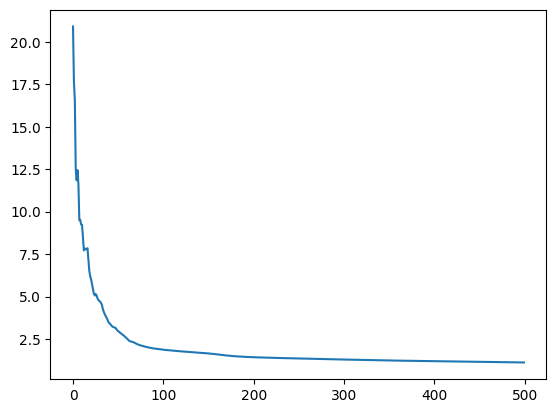

In [7]:
plt.style.use("default")
np.save(path+"/map.npy",map_estimate)
plt.plot(np.array(chi))
plt.savefig(path+"/chi-squared.png")

In [8]:
start = time.perf_counter()
print(datetime.now())

try:
    lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=n_samples_bs), map_estimate)[0]
    best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]
except:
    map_estimate=np.load(path+"/map.npy")
    lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=n_samples_bs), map_estimate)[0]
    best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]

end = time.perf_counter()
logProbTime = end-start
print(logProbTime)

2024-07-18 10:30:04.562364
58.75428754510358


In [9]:
np.save(path+"/best.npy",best)

1.1226724
[[{'theta_E': Array(1.4781008, dtype=float32), 'gamma': Array(2.1986475, dtype=float32), 'e2': Array(-0.05491608, dtype=float32), 'e1': Array(-0.1396249, dtype=float32), 'center_y': Array(-0.13498308, dtype=float32), 'center_x': Array(-0.18157782, dtype=float32)}, {'gamma2': Array(-0.06599642, dtype=float32), 'gamma1': Array(0.14508502, dtype=float32)}], [{'n_sersic': Array(4.0845833, dtype=float32), 'e2': Array(0.08920631, dtype=float32), 'e1': Array(-0.08671913, dtype=float32), 'center_y': Array(-0.11147269, dtype=float32), 'center_x': Array(-0.11698429, dtype=float32), 'R_sersic': Array(0.773722, dtype=float32)}, {'n_sersic': Array(1.9836421, dtype=float32), 'e2': Array(0.18163472, dtype=float32), 'e1': Array(-0.1525255, dtype=float32), 'center_y': Array(-0.08822481, dtype=float32), 'center_x': Array(-0.10728122, dtype=float32), 'R_sersic': Array(0.40374216, dtype=float32)}, {'n_sersic': Array(6.5875206, dtype=float32), 'e2': Array(0.21271417, dtype=float32), 'e1': Array(-

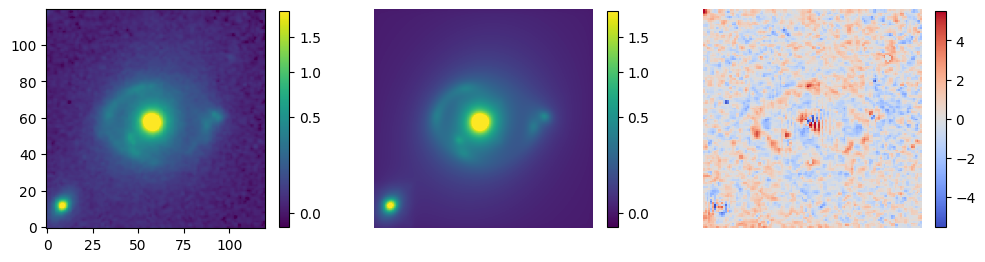

In [10]:
params = prob_model.bij.forward(best.tolist()[0])
simulated = lens_sim.lstsq_simulate(params,jnp.array(observed_img),err_map)[0]

plt.figure(figsize=(12, 4))

plt.subplot(131)
norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar(shrink=0.7)

plt.subplot(132)
plt.imshow(simulated, norm=norm, origin='lower', cmap='viridis')
plt.colorbar(shrink=0.7)
plt.axis('off')

plt.subplot(133)
resid = jnp.array(observed_img) - simulated
plt.imshow(resid/err_map, cmap='coolwarm', origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)

MAPchi = np.mean((resid/err_map)**2)
plt.axis('off')
plt.colorbar(shrink=0.7)

print(MAPchi)
plt.savefig(path+"/MAPoutput.png")
print(params)

ELBO: -45589.254: 100%|██████████| 6000/6000 [14:20<00:00,  6.97it/s]


Normal SVI success
862.7223185529001


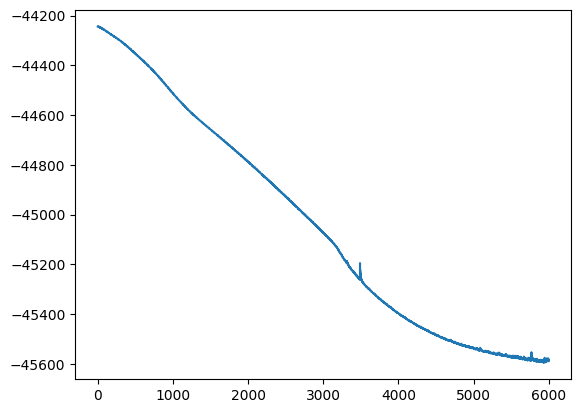

In [11]:
start = time.perf_counter()
steps=6000

try:
    schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-1e-3, power=0.5, transition_steps=steps)
    opt = optax.chain(optax.scale_by_adam(),optax.scale_by_schedule(schedule_fn),)
    qz, loss_hist = model_seq.SVI(best, opt, n_vi=2000, num_steps=steps)
        
    plt.plot(loss_hist)
    plt.savefig(path+"/SVIloss.png")
    
    mean=qz.mean()
    cov=qz.covariance()
    scale = np.linalg.cholesky(cov)
    
    printToFile("Normal SVI success",path+"output.txt")
except: 
    
    printToFile("Normal SVI failed, skipping...",path+"output.txt")
    schedule_fn = optax.polynomial_schedule(init_value=0, end_value=-1e-15, power=2, transition_steps=500)
    opt = optax.chain(optax.scale_by_adam(),optax.scale_by_schedule(schedule_fn),)
    qz, loss_histFAIL = model_seq.SVI(best, opt, n_vi=500, num_steps=500)
    
    mean=qz.mean()
    cov=qz.covariance()
    scale = np.linalg.cholesky(cov)

end = time.perf_counter()
SVItime = end-start

print(SVItime)

In [ ]:
start = time.perf_counter()
print(datetime.now())
num_samples = 3000
samples = model_seq.david_HMC(qz, num_burnin_steps=1000, num_results=num_samples, num_steps_between_results=5, accept=0.6)
end = time.perf_counter()

HMCtime = end-start
#np.save(path+"/HMC.npy",samples)
print(HMCtime)

2024-07-18 10:58:58.905939
1
2
3


In [ ]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
print(rhat)

In [29]:
smp = jnp.transpose(samples.all_states, (1,2,0,3)).reshape((-1, myfunctions.countParameters(phys_model)))
smp_physical = prob_model.bij.forward(list(smp.T))

stack = []
for ii, priorSet in enumerate(priorObjects):
    for iii, priorObject in enumerate(priorSet):
        if priorObject == "EPL":
            stack.extend([
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
                            smp_physical[ii][iii]["e1"],
                            smp_physical[ii][iii]["e2"],
                            smp_physical[ii][iii]["gamma"],
                            smp_physical[ii][iii]["theta_E"],
            ])
        elif priorObject == "SHEAR":
            stack.extend([
                            smp_physical[ii][iii]["gamma1"],
                            smp_physical[ii][iii]["gamma2"],
            ])
        elif priorObject == "SERSIC_ELLIPSE":
            stack.extend([
                            smp_physical[ii][iii]["R_sersic"],
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
                            smp_physical[ii][iii]["e1"],
                            smp_physical[ii][iii]["e2"],
                            smp_physical[ii][iii]["n_sersic"],
            ])
        elif priorObject == "SHAPELETS":
            stack.extend([
                            smp_physical[ii][iii]["beta"],
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
            ])
        elif priorObject == "SIS":
            stack.extend([
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
                            smp_physical[ii][iii]["theta_E"],
            ])
            
get_samples = np.column_stack(stack)
physical_samples = get_samples

reversed_physical_samples = np.zeros([num_samples*16,numParams])
reversed_physical_samples[:,0:6]=np.flip(physical_samples[:,0:6])
reversed_physical_samples[:,6:8]=np.flip(physical_samples[:,6:8])
reversed_physical_samples[:,8:numParams] = physical_samples[:,8:numParams]

best_HMC=prob_model.pack_bij.forward(np.median(physical_samples,axis=0).tolist())
with open(path+"/bestHMC.json","w") as file:
    json.dump(best_HMC,file,indent=4)

peepeepoopoo


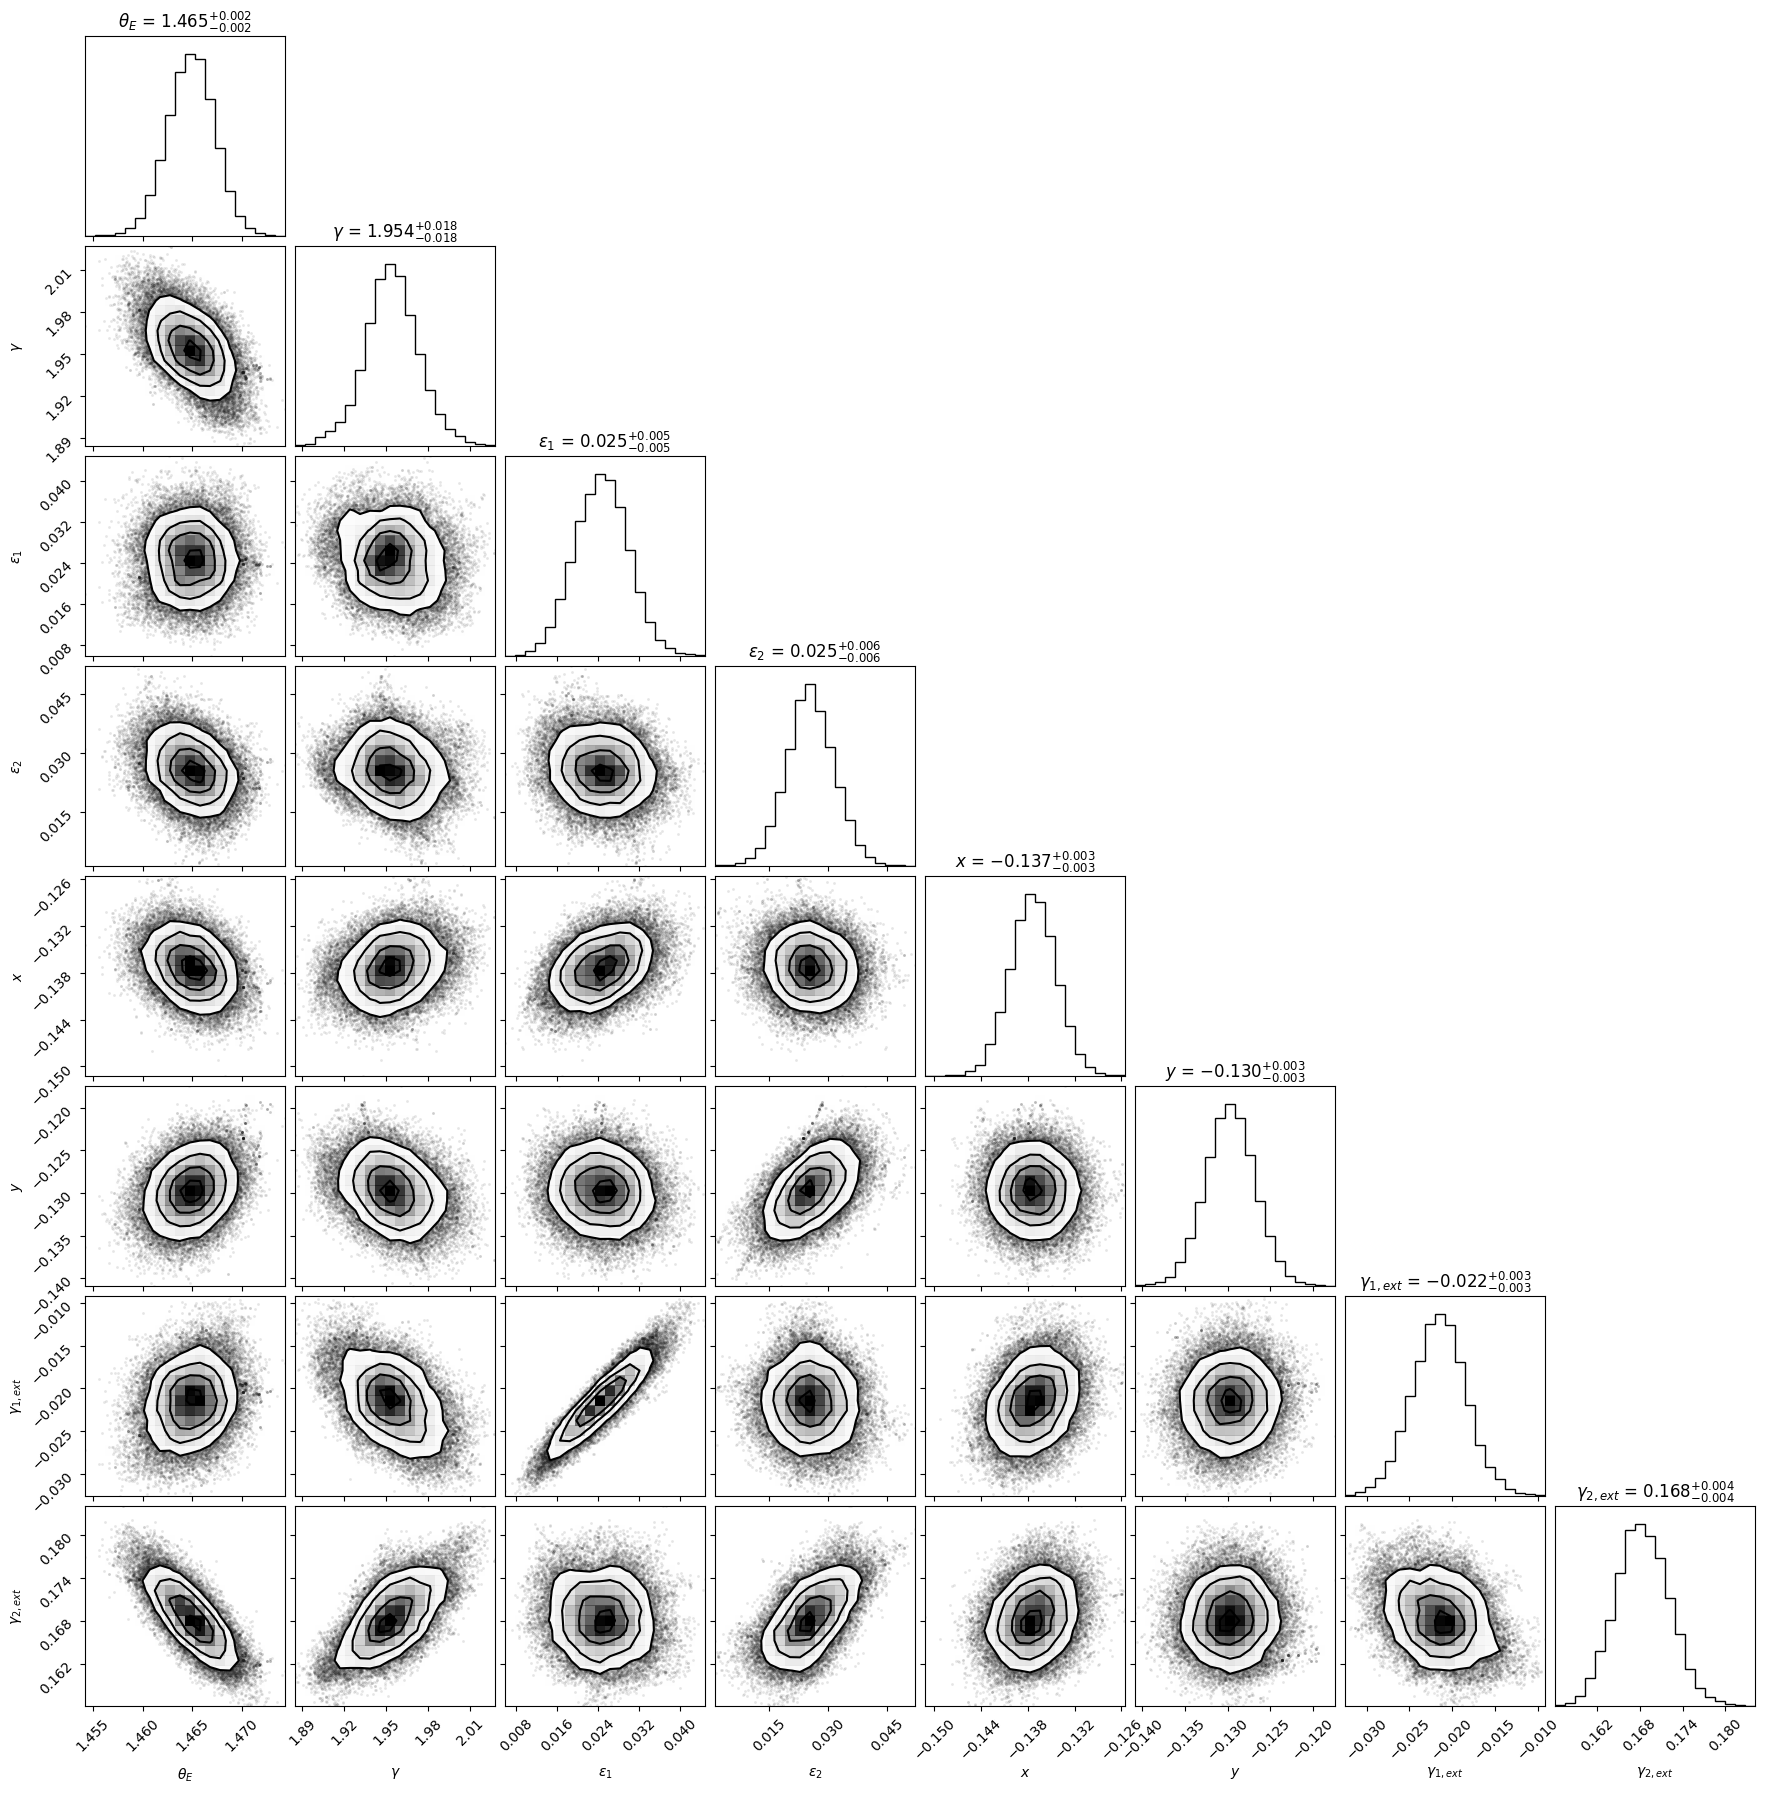

In [30]:
plt.style.use('default')

labels=[r'$\theta_E$', 
        r'$\gamma$', 
        r'$\epsilon_1$', 
        r'$\epsilon_2$', 
        r'$x$', r'$y$', 
        r'$\gamma_{1,ext}$', 
        r'$\gamma_{2,ext}$']

corner(reversed_physical_samples[:,0:8], show_titles=True, title_fmt='.3f', labels=labels)
print("peepeepoopoo")
plt.savefig(path+"corner.png")

In [ ]:
corner(reversed_physical_samples, show_titles=True, title_fmt='.3f', );
plt.savefig(path+"bigcorner.png")

In [ ]:
simulated, coeffs = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)
resid = jnp.array(observed_img) - simulated
chi2 = np.sum((resid/err_map)**2)
dof = len(np.reshape(err_map,-1)[np.reshape(err_map,-1)<1])-numParams
HMCchi = chi2/dof

In [ ]:
printToFile(now+"\n", path+"output.txt")
printToFile(str(jax.devices())+"\n", path+"output.txt")
printToFile(str([numParams,priorObjects]),path+"output.txt")

In [ ]:
printToFile("MAP took "+str(MAPtime)+" seconds \n",path+"output.txt")
printToFile("log_prob took "+str(logProbTime)+" seconds \n",path+"output.txt")
printToFile('MAP chi-squared: '+str(MAPchi)+ "\n",path+"output.txt")

In [ ]:
printToFile("SVI took "+str(SVItime)+" seconds \n",path+"output.txt")
printToFile("HMC took "+str(HMCtime)+" seconds \n",path+"output.txt")
printToFile('HMC chi-squared: '+str(HMCchi)+ "\n",path+"output.txt")
printToFile('Rhat: '+str(rhat),path+"output.txt")

In [ ]:
for i in range(0,len(best_HMC[0])):
    printToFile("lens: "+ str([[ii,float(best_HMC[0][i][ii])] for ii in best_HMC[0][i]])+ "\n",path+"output.txt")

for i in range(0,len(best_HMC[1])):
    printToFile("lens light: "+ str([[ii,float(best_HMC[1][i][ii])] for ii in best_HMC[1][i]])+ "\n",path+"output.txt")

for i in range(0,len(best_HMC[2])):
    printToFile("source light: "+ str([[ii,float(best_HMC[2][i][ii])] for ii in best_HMC[2][i]])+ "\n",path+"output.txt")